<a href="https://colab.research.google.com/github/codekali/Neural-SC-Descriptor/blob/master/FinalTrial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Mount google drive, install dependencies and import required packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/Transformer/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Transformer


In [ ]:
# Install transformers
!pip install transformers

In [ ]:
import torch
import os.path
from os import path
import matplotlib.pyplot as plt
from torch.utils import data
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from src import utils
from transformers import T5Tokenizer, T5ForConditionalGeneration

model_path = "checkpoint.pth"

# Retrieve training and validation data from google drive

In [ ]:
X_train,Y_train = [],[]  
fileX = open("train/train.token.sbt")
fileY = open("train/train.token.nl")

for i, lineX, lineY in zip(range(150000), fileX, fileY):
  X_train.append(lineX)
  Y_train.append(lineY)

print("Number of Training Example: ", len(X_train))

Number of Training Example:  150000


In [ ]:
X_valid,Y_valid = [],[]
fileX = open("val/valid.token.sbt")
fileY = open("val/valid.token.nl")

for lineX, lineY in zip(fileX, fileY):
  X_valid.append(lineX)
  Y_valid.append(lineY)
# X_valid,Y_valid = X_valid[50:70],Y_valid[50:70]
print("Number of validation Example: ", len(X_valid))

Number of validation Example:  20


# Dataset Class to load data while training and validation

In [ ]:
class Dataset(data.Dataset):
  def __init__(self, X_item, Y_item):
    self.X_item=X_item
    self.Y_item=Y_item

  def __len__(self):
    return len(self.X_item)

  def __getitem__(self, index):
    X = self.X_item[index]
    
    Y = self.Y_item[index]
    return X, Y

# Take GPU into action and define batch size and num of workers

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(">>> ", device)
params = {'batch_size': 4,
          'shuffle': True,
          'num_workers': 0}

params_valid = {'batch_size': 4,
          'shuffle': False,
          'num_workers': 0}

training_set = Dataset(X_train,Y_train)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(X_valid,Y_valid)
validation_generator = data.DataLoader(validation_set, **params_valid)


>>>  cuda


## Load Initial Model and Tokenizer

In [ ]:
#load pre-trained model and tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')
model = model.to(device)

#load opptimizer
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_grouped_parameters = []
lr=9e-5
for key, value in dict(model.named_parameters()).items():
    if value.requires_grad:
        if any(nd in key for nd in no_decay):
            optimizer_grouped_parameters += [
                {"params": [value], "lr": lr, "weight_decay": 0.01}
            ]
        if not any(nd in key for nd in no_decay):
            optimizer_grouped_parameters += [
                {"params": [value], "lr": lr, "weight_decay": 0.0}
            ]
                
optimizer = utils.BertAdam(
            optimizer_grouped_parameters,
            lr=lr,
            warmup=0.1,
            t_total=100,
            schedule='warmup_constant',
        )

# Training variables

loss_train = []
loss_valid = []
trainloss=0
validloss=0
epoch = 0
num_epoch = 35


## Load model, tokenizer, optimizer, trainer, epoch no. and losses from a checkpoint directly or from the saved location.

In [ ]:
model_location = "models/" + model_path

if path.exists(model_location):

  #load saved model from the drive
  checkpoint = torch.load(model_location)
  epoch = checkpoint['epoch']
  model.load_state_dict(checkpoint["state_dict"])
  optimizer.load_state_dict(checkpoint['optimizer'])
  loss_train = checkpoint['trainloss']
  loss_valid = checkpoint['validloss']
  print(">>> loaded saved checkpoint from epoch ", epoch)
  model = model.to(device)

else:
  print(">>> loaded from downloaded model ")

>>> loaded saved checkpoint from epoch  30


## Plot train and valid loss to see the curve

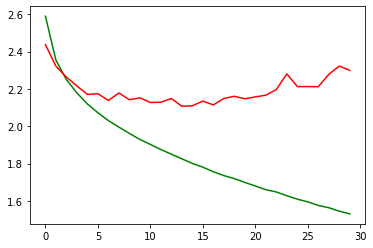

In [ ]:
plt.plot(loss_train, color="green")
plt.plot(loss_valid, color="red")
plt.show()

In [ ]:
best_f1=checkpoint['F1']
best_model=checkpoint
if path.exists("models/best.pth"):
  best_model = torch.load("models/best.pth")
  best_f1=best_model['F1']
print(best_f1)

0.26039345916179746


# Training and validation loop

In [ ]:

while epoch < num_epoch:

  trainloss = 0
  validloss = 0  
  print("Running EPOCH : ", epoch+1)

  """Training"""
  model.train()
  for local_batch, local_labels in tqdm(training_generator): 


    """Forward Function Implementation"""
    input_ids = tokenizer.batch_encode_plus(local_batch, return_tensors="pt",pad_to_max_length=True)
    label = tokenizer.batch_encode_plus(local_labels, return_tensors="pt",pad_to_max_length=True)
    
    outputs = model(input_ids=(input_ids['input_ids']).to(device), lm_labels=(label['input_ids']).to(device),attention_mask=(input_ids['attention_mask']).to(device))
    loss = outputs[0]
    """Forward Function Ends here"""
    
    """Loss and optimizer"""
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    trainloss += round(loss.data.item(), 4)

  trainloss = trainloss/len(training_generator)
  loss_train.append(trainloss)

  """Validation"""
  model.eval()
  with torch.set_grad_enabled(False):
    refs_list = []
    hyp_list = []
    for local_batch, local_labels in tqdm(validation_generator):
      input_ids = tokenizer.batch_encode_plus(local_batch, return_tensors="pt",pad_to_max_length=True)
      label = tokenizer.batch_encode_plus(local_labels, return_tensors="pt",pad_to_max_length=True)
      
      outputs = model(input_ids=(input_ids['input_ids']).to(device), lm_labels=(label['input_ids']).to(device))

      predY = model.generate(input_ids=(input_ids['input_ids']).to(device))
          
      for i,j in zip(predY, local_labels):
        hyp_list.append(tokenizer.decode(i))
        refs_list.append(j)
        
      validloss += outputs[0]   

  validloss = validloss / len(validation_generator)
  loss_valid.append(validloss)

  precision, recall, f1 = utils.calculate_results(refs_list, hyp_list)  

  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.plot(loss_train, color='green', label="Train Loss")
  
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.plot(loss_valid, color='red', label="Valid Loss")
  
  plt.legend()
  plt.show()

  print("\nEpoch ", epoch+1, " completed! \nTrain loss is: ", trainloss, "\nValid loss is: ", validloss)  
  
  print("For Epoch:",epoch+1)
  print("Precision: ", precision)
  print("Recall: ", recall)
  print("f1: ", f1)
  """Save states"""
  states = {
          'epoch': epoch + 1,
          'state_dict': model.state_dict(),
          'optimizer': optimizer.state_dict(),
          'trainloss': loss_train,
          'validloss': loss_valid,
          'F1': f1
      }
  if f1>best_f1:
    best_f1=f1
    print("Saving the best model")
    torch.save(states, "models/best.pth")
  
  print("Saving the regular model")
  torch.save(states, "models/" + model_path)
  print("\n\n", "_"*100 , "\n\n")

  epoch += 1

## Load Test Data

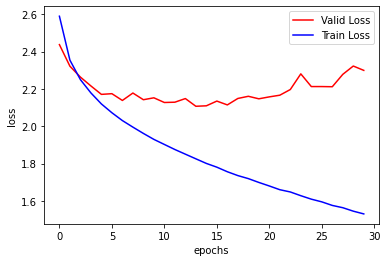

In [ ]:
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(loss_valid, color='red', label="Valid Loss")
plt.plot(loss_train, color='blue', label="Train Loss")
plt.legend()
plt.show()

In [ ]:
X_test,Y_test = [],[]
file=open("test/test.token.sbt")
for line in file:
  X_test.append(line)
file=open("test/test.token.nl")
for line in file:
  Y_test.append(line)

X_test=X_test[50:70]
Y_test=Y_test[50:70]
print(len(X_test))
  
# Data loader for test set
test_set = Dataset(X_test,Y_test)
test_generator = data.DataLoader(test_set, **params_valid)

20


## Make target and predicted list

In [ ]:
refs_list = []
hyp_list = []

with torch.set_grad_enabled(False):
  for local_batch, local_labels in tqdm(validation_generator):
    input_ids = tokenizer.batch_encode_plus(local_batch, return_tensors="pt",pad_to_max_length=True)
    
    model.eval()
    predY = model.generate(input_ids=(input_ids['input_ids']).to(device))
    
    for i,j in zip(predY, local_labels):
      hyp_list.append(tokenizer.decode(i))
      refs_list.append(j)

In [ ]:
precision, recall, f1 = utils.calculate_results(refs_list, hyp_list)
print("Precision: ", precision)
print("Recall: ", recall)
print("f1: ", f1)

Precision:  0.24074074074074073
Recall:  0.21428571428571427
f1:  0.22674418604651161


In [ ]:
bleu_multi = utils.
print("Multi Bleu score: ", bleu_multi)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method7
bleu_score = 0.0
refs=[]
hyp=[]
for i in range(len(refs_list)):
  refs.append([refs_list[i].strip().split()])
  hyp.append(hyp_list[i].strip().split())
print(hyp)
#bleu_score2 = corpus_bleu(refs, hyp,smoothing_function=smoothie)
bleu_score2 = corpus_bleu(refs, hyp)
print("The bleu score is: "+str(bleu_score2*100))

[['run', 'just', 'this', 'test.'], ['create', 'a', 'stream', 'of', 'all', 'the', 'tuples', 'in', 'the', 'given', 'stream.'], ['construct', 'the', 'stub', 'at', 'attach', 'it', 'to', 'the', 'interface.'], ['creates', 'a', 'new', 'ui', 'object', 'for', 'the', 'given', 'component.'], ['adds', 'a', 'new', 'entry', 'to', 'the', 'xml', 'element.'], ['constructs', 'a', 'new', 'set', 'of', 'nodes', 'with', 'the', 'given', 'parent', 'and', 'list', 'of', 'nodes'], ['used', 'to', 'communicate', 'feedback', 'pop', 'up', 'messages', 'between', 'a', 'plugin', 'tool', 'and', 'the', 'main', 'whitebox', 'user', 'interface'], ['creates', 'a', 'new', 'jmx', 'connection.'], ['this', 'method', 'converts', 'device', 'specific', 'pixels', 'to', 'density', 'independent', 'pixels.'], ['used', 'to', 'communicate', 'a', 'return', 'object', 'from', 'a', 'plugin', 'tool', 'to', 'the', 'main', 'whitebox', 'user', 'interface'], ['creates', 'a', 'new', 'instance', 'of', 'ngramsnavigable'], ['logs', 'the', 'dbsvc', 'd

In [ ]:
for i in range(len(hyp_list)):
  print(refs_list[i],"-->",hyp_list[i])

decrypts the given data with a symmetric key generated using shared secret .
 --> decrypts the given url using the encrypted crypt.
removes aliases from a san fabric of given network system .
 --> creates a new instance of a given class.
tell if this object contains a java string object .
 --> returns true if the underlying jvm supports the jmx.
all the shards replicas for all indices in this routing table .
 --> returns all the urls of this uri.
parses the supplied xsd float string and returns its value .
 --> returns true if the given url is a url.
returns lowest node .
 --> returns the type of the given key in a subtype like map.
create agents as members of this population .
 --> generates a list of shards that are managed by the given shard
check a property .
 --> adds a new node to the list.
clear the local map .
 --> destruction of the servlet.
the main method which is called by the command lines .
 --> updates the ui for the current state of the button.
returns a set of privileg

In [ ]:
f = open("src/reference.txt", "w")
for i in range(len(refs_list)):
  f.write(refs_list[i])
f.close()
f = open("src/hypothesis.txt", "w")
for i in range(len(hyp_list)):
  f.write(hyp_list[i])
f.close()

In [ ]:
bleu_multi = utils.compute_bleu("reference.txt","hypothesis.txt")
print("Multi bleu score is: ",bleu_multi)

AttributeError: ignored

In [ ]:
from __future__ import print_function
from nltk.metrics import *
p=0.0
r=0.0
for x in range(len(refs_list)):
    if set(hyp_list[x].split())==set() or set(refs_list[x].split())==set():
      continue
    p+=precision(set(refs_list[x].split()),set(hyp_list[x].split()))
    r+=recall(set(refs_list[x].split()),set(hyp_list[x].split()))

print(p/len(refs_list))
print(r/len(refs_list))

In [ ]:
x=132
print(refs_list[x])
print(hyp_list[x])

In [ ]:
x=65001
ip = tokenizer.encode(X_train[x], return_tensors="pt",pad_to_max_length=True)
pred = model.generate(input_ids=(ip).to(device))
print(tokenizer.decode(pred[0]))
print(Y_train[x])